In [1]:
import numpy as np
import matplotlib.pyplot as plt
import natsort, glob, h5py
from scipy.optimize import curve_fit
import scipy.signal

In [2]:
#path = r"C:/Data/20220630/LXe_Full_E_field_-2kV_source_reposition_Gain_source_removed/"
path = '/gpfs/gibbs/project/david_moore/mpw46/purity_monitor/20230213/step5/'
SRS_gain = 100 # gain on the SRS bandpass filter
peak_threshold = 700 # upper bound of pedestal
breakdown = 27.4 # breakdown voltage of the SiPM
pedestal = 275 # center of noise pedestal peak

file_list = natsort.realsorted(glob.glob(path + "mca_*.h5"))[::-1]
print("Found %d files"%len(file_list))

Found 10 files


In [3]:
def gauss_fun(x, A, mu, sig):
    return A * np.exp( -(x-mu)**2/(2*sig**2) )

def lin_fun(x, m, x1):
    return m*(x-x1)

def lin_fun_const(x, m):
    return lin_fun(x,m,0)

In [4]:
def rebin_histogram(bins, counts, new_bin_size):
    """Rebin a histogram to a new bin size.
    Parameters:
        bins (np.ndarray): The bin edges of the histogram.
        counts (np.ndarray): The number of counts in each bin.
        new_bin_size (float): The size of the new bins.
    Returns:
        np.ndarray: The new bin edges.
        np.ndarray: The new bin counts.
    """
    # Find the new number of bins
    new_nbins = int((bins[-1] - bins[0]) / new_bin_size)
    # Create the new bin edges
    new_bins = np.linspace(bins[0], bins[-1], new_nbins + 1)
    # Digitize the original bins into the new bins
    digitized_bins = np.digitize(bins, new_bins)
    # Calculate the new counts
    new_counts = np.array([counts[digitized_bins == i].sum() for i in range(1, new_nbins + 1)])

    new_centers = new_bins[:-1] + np.diff(new_bins)/2
    return new_centers, new_counts

In [64]:
def find_peaks_and_fit(x_data, y_data, min_distance=20, max_peaks=5, min_thresh=10, binsize=50):
    # rebin data to make the histogram bins less small
    x, y = rebin_histogram(x_data, y_data, binsize)
    
    # Find the peaks in the spectrum using the find_peaks function from scipy.signal
    peaks_index, _ = scipy.signal.find_peaks(y, distance=min_distance)

    # Fit each peak with a Gaussian function using the curve_fit function from scipy
    peak_params = []
    peak_number = 1 # corresponds to single photoelectron
    for peak in peaks_index:
        if peak_number > max_peaks: # stopping the loop after we have reached the max number of peaks
            break

        if peak < min_thresh:
            continue

        # Initial guess for the Gaussian parameters
        amplitude_guess = y[peak]
        mean_guess = x[peak]
        standard_deviation_guess = 50
        initial_guess = [amplitude_guess, mean_guess, standard_deviation_guess]
        
        # finding the section of the data around the given peak
        if peak_number == 1: # trying to not include the pedestal for the first peak
            cut = (x < (x[peak] + 500)) & (x > (x[peak] - 200))
        else:
            cut = (x < (x[peak] + 500)) & (x > (x[peak] - 500))
        peak_x = x[cut]
        peak_y = y[cut]
        
        # Perform the curve fitting
        try:
            # trying to fit the peaks
            params, params_covariance = curve_fit(gauss_fun, peak_x, peak_y, p0=initial_guess)
            print('Guess: ', initial_guess)
            print('Params: ', params)
        except RuntimeError as r:
            # if curve fit doesn't work then we will just use the peak amplitude and center that find_peaks found
            print('fit failed')
            peak_params.append([peak, np.nan, np.nan])
            xx = np.linspace( x[peak] - 2*standard_deviation_guess, x[peak] + 2*standard_deviation_guess, 100 )
            plt.plot( xx, gauss_fun(xx, *initial_guess), 'b' )
            continue
        peak_params.append([peak_number, params[1], np.sqrt(params_covariance[1,1])])
        peak_number+=1 # (goes to n*spe until it reaches max_peak)
    
    # Plot the original spectrum and the fitted Gaussian peaks
        plt.plot(peak_x, peak_y, color='b')
        plt.plot(x[peak], y[peak], 'o', label='peaks')
#     plt.plot(x, y, 'o', label='Original spectrum')
    for params in peak_params:
        print(params)
        plt.plot(x, gauss_fun(x, *params), label='Fitted peak')
    #plt.legend()
    plt.show()
    return np.array(peak_params), x, y

In [67]:
pe_locs

array([[1.00000000e+00, 9.43716214e+02, 1.27140844e+02],
       [3.00000000e+01,            nan,            nan],
       [4.00000000e+01,            nan,            nan],
       [4.90000000e+01,            nan,            nan],
       [6.00000000e+01,            nan,            nan],
       [2.00000000e+00, 3.29134271e+03, 1.05813599e+02],
       [3.00000000e+00, 2.86653624e+03, 2.39995103e+03],
       [7.80000000e+01,            nan,            nan],
       [4.00000000e+00, 2.20964402e+03, 3.62001536e+04],
       [9.20000000e+01,            nan,            nan],
       [5.00000000e+00, 3.28507789e+03, 1.66363855e+04]])

Working on file #0: /gpfs/gibbs/project/david_moore/mpw46/purity_monitor/20230213/step5/mca_keith_33.90OV_source_0.h5
Distance:  20
Guess:  [442, 1628.2798165137615, 50]
Params:  [ 423.8980657  1614.94424884  141.72362772]
Guess:  [171, 3181.4082568807344, 50]
Params:  [ 153.46948934 3151.46598307  144.25613851]
Guess:  [76, 4634.334862385322, 50]
Params:  [  65.68425037 4675.13178563  203.66877728]
Guess:  [46, 6237.564220183487, 50]
Params:  [  37.08935475 6196.07948279  233.09980951]
Guess:  [28, 7690.4908256880735, 50]
Params:  [  21.69430991 7716.34592986  349.2459008 ]
[1, 1614.9442488449176, 10.170598925507157]
[2, 3151.4659830741343, 8.533615115391894]
[3, 4675.131785631012, 13.273759353176064]
[4, 6196.079482785532, 19.093229078846335]
[5, 7716.345929858367, 27.71623731717541]


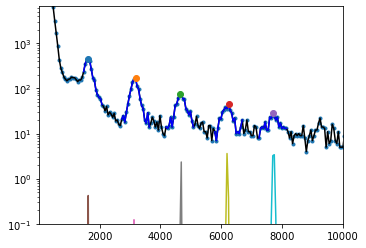

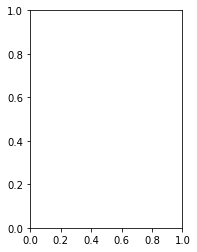

Working on file #1: /gpfs/gibbs/project/david_moore/mpw46/purity_monitor/20230213/step5/mca_keith_33.40OV_source_0.h5
Distance:  20
Guess:  [551, 1477.9770642201836, 50]
Params:  [ 504.26994158 1496.17009046  143.50475538]
Guess:  [177, 2930.903669724771, 50]
Params:  [ 164.8745306  2924.95983093  141.65166197]
Guess:  [105, 4333.729357798165, 50]
Params:  [  75.7406154  4337.88689373  182.98114471]
Guess:  [54, 5736.55504587156, 50]
Params:  [  43.3316268  5749.35004879  228.62921061]
Guess:  [36, 7239.58256880734, 50]
Params:  [  22.77864241 7198.8115799   313.09466194]
[1, 1496.17009045558, 6.2202501939757555]
[2, 2924.9598309276907, 9.66717824323407]
[3, 4337.8868937322495, 15.722921910562517]
[4, 5749.350048792815, 18.492462311809508]
[5, 7198.811579896141, 37.52876819512285]


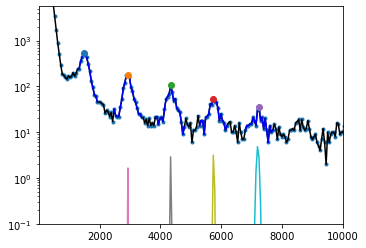

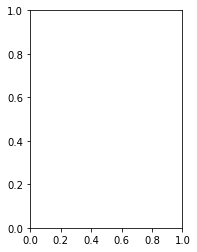

Working on file #2: /gpfs/gibbs/project/david_moore/mpw46/purity_monitor/20230213/step5/mca_keith_32.90OV_source_0.h5
Distance:  20
Guess:  [539, 1377.7752293577983, 50]
Params:  [ 535.7498037  1381.28324305  141.7146014 ]
Guess:  [177, 2680.3990825688074, 50]
Params:  [ 165.6044545  2700.09942193  145.7101276 ]
Guess:  [87, 3983.022935779817, 50]
Params:  [  73.18114797 4007.72341511  183.0738058 ]
Guess:  [46, 5335.747706422018, 50]
Params:  [  35.07646582 5315.39980864  231.40017202]
Guess:  [31, 6638.371559633028, 50]
Params:  [  26.1021674  6622.94857344  226.24492767]
[1, 1381.283243046974, 7.328697377380372]
[2, 2700.099421934492, 9.62722957813652]
[3, 4007.7234151080584, 15.416053192186169]
[4, 5315.399808642775, 23.81846499360655]
[5, 6622.948573436408, 21.165884438679452]


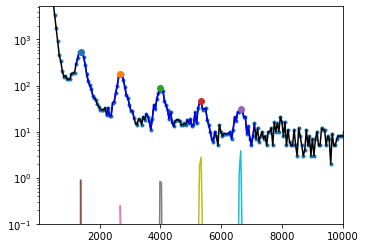

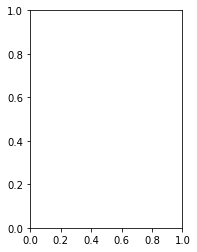

Working on file #3: /gpfs/gibbs/project/david_moore/mpw46/purity_monitor/20230213/step5/mca_keith_32.40OV_source_0.h5
Distance:  20
Guess:  [588, 1277.573394495413, 50]
Params:  [ 579.28744449 1271.81877611  133.16258768]
Guess:  [207, 2479.9954128440368, 50]
Params:  [ 188.38108757 2468.81439237  140.09193969]
Guess:  [75, 3682.417431192661, 50]
Params:  [  68.83967189 3666.1371328   197.81815752]
Guess:  [54, 4884.839449541285, 50]
Params:  [  36.32301736 4879.15884467  236.10779013]
Guess:  [31, 6037.160550458716, 50]
Params:  [  22.87044715 6060.01826463  313.07438172]
[1, 1271.8187761091026, 5.331485060424449]
[2, 2468.814392371609, 8.756430841019686]
[3, 3666.137132800427, 11.860395862006692]
[4, 4879.158844674355, 26.968159162588183]
[5, 6060.01826462736, 39.34270820623633]


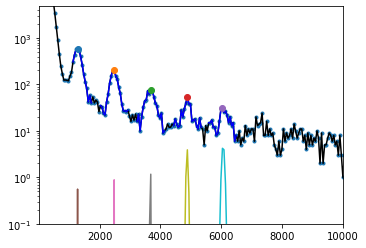

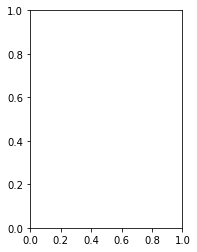

Working on file #4: /gpfs/gibbs/project/david_moore/mpw46/purity_monitor/20230213/step5/mca_keith_31.90OV_source_0.h5
Distance:  15
Guess:  [603, 1127.270642201835, 50]
Params:  [ 588.4628936  1165.20321887  124.07264827]
Guess:  [206, 2229.4908256880735, 50]
Params:  [ 180.93775744 2251.3431874   153.75682279]
Guess:  [100, 3331.711009174312, 50]
Params:  [  78.14120786 3317.8125101   186.99495353]
Guess:  [49, 4333.729357798165, 50]
Params:  [  39.42002958 4362.25430973  232.89502064]
Guess:  [30, 5385.848623853211, 50]
Params:  [  26.62723691 5455.77182835  234.62113256]
[1, 1165.203218870846, 5.455001544966365]
[2, 2251.3431873953596, 10.735722335971984]
[3, 3317.812510098657, 13.153997839092742]
[4, 4362.254309734803, 21.864807439660872]
[5, 5455.77182835336, 17.913769594150132]


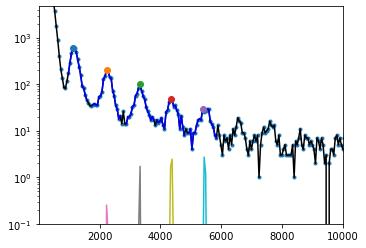

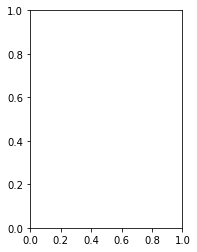

Working on file #5: /gpfs/gibbs/project/david_moore/mpw46/purity_monitor/20230213/step5/mca_keith_31.40OV_source_0.h5
Distance:  15
Guess:  [646, 1027.0688073394497, 50]
Params:  [ 609.96492217 1053.44164888  122.25275658]
Guess:  [188, 1978.9862385321103, 50]
Params:  [ 177.69953143 2005.97415638  143.86212258]
Guess:  [88, 2981.0045871559632, 50]
Params:  [  76.52143321 2972.23856697  167.99097333]
Guess:  [53, 3932.922018348624, 50]
Params:  [  39.64023767 3930.71073273  208.10793222]
Guess:  [27, 4985.04128440367, 50]
Params:  [  22.6746681  4935.57868044  217.97240263]
[1, 1053.4416488769305, 5.018014567735504]
[2, 2005.974156376439, 8.258639002066415]
[3, 2972.2385669710275, 11.733534264134558]
[4, 3930.7107327343165, 21.51035000562877]
[5, 4935.578680436214, 19.208350826443475]


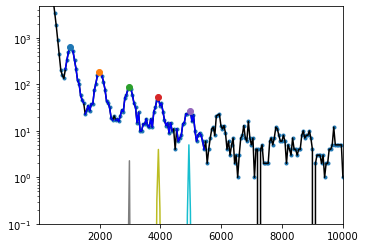

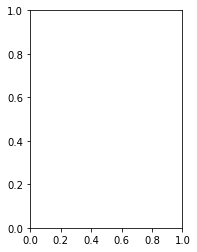

Working on file #6: /gpfs/gibbs/project/david_moore/mpw46/purity_monitor/20230213/step5/mca_keith_30.90OV_source_0.h5
Distance:  15
Guess:  [605, 926.8669724770643, 50]
Params:  [599.76366586 927.38915574 123.57193493]
Guess:  [205, 1778.5825688073396, 50]
Params:  [ 190.98391455 1775.10206147  137.47686037]
Guess:  [90, 2630.298165137615, 50]
Params:  [  73.52291632 2606.62261253  163.06115112]
Guess:  [44, 3482.0137614678897, 50]
Params:  [  37.47717588 3468.95305622  200.26973816]
Guess:  [30, 4283.628440366972, 50]
Params:  [  23.64446335 4293.99425306  200.14570308]
[1, 927.3891557400694, 5.054842685702639]
[2, 1775.102061472305, 7.668363013408854]
[3, 2606.6226125321814, 14.779671233492389]
[4, 3468.9530562215086, 18.663441190424297]
[5, 4293.994253064579, 24.121412028255417]


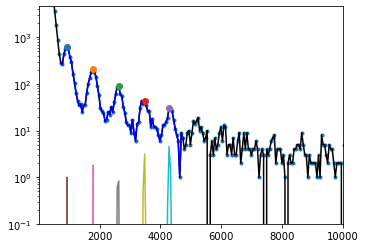

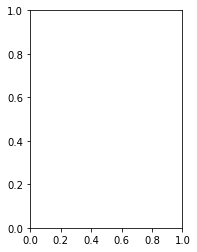

Working on file #7: /gpfs/gibbs/project/david_moore/mpw46/purity_monitor/20230213/step5/mca_keith_30.40OV_source_0.h5
Distance:  10
Guess:  [675, 776.5642201834862, 50]
Params:  [785.00197521 647.62683801 221.21470396]
Guess:  [191, 1528.0779816513764, 50]
Params:  [ 172.57373818 1532.74989367  140.21932691]
Guess:  [66, 2229.4908256880735, 50]
Params:  [  56.71430288 2237.18790288  191.98231875]
Guess:  [50, 2981.0045871559632, 50]
Params:  [  35.022635   2993.47940234  152.76488687]
Guess:  [26, 3732.5183486238534, 50]
Params:  [  23.47088635 3703.56480385  188.17301238]
[1, 647.6268380128214, 56.42454281687885]
[2, 1532.7498936684449, 14.087000793829207]
[3, 2237.1879028752437, 20.69954841732431]
[4, 2993.479402341994, 17.875718475894164]
[5, 3703.5648038489326, 17.363291248726217]


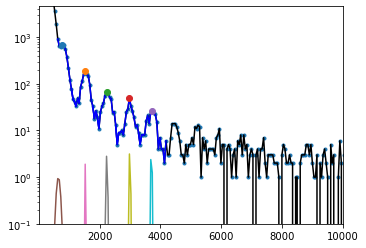

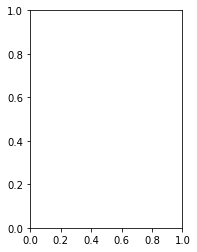

Working on file #8: /gpfs/gibbs/project/david_moore/mpw46/purity_monitor/20230213/step5/mca_keith_29.90OV_source_0.h5
Distance:  10
Guess:  [181, 1277.573394495413, 50]
Params:  [ 165.24619166 1291.19678524  131.80377296]
Guess:  [69, 1878.7844036697247, 50]
Params:  [  53.88359258 1351.23695206  663.31988073]
Guess:  [42, 2479.9954128440368, 50]
Params:  [  32.60560937 2451.77567454  248.73961655]
Guess:  [29, 3081.206422018349, 50]
Params:  [  15.75903124 2949.90764666  430.92454627]
Guess:  [22, 3682.417431192661, 50]
Params:  [  28.29448832    4.81483101 2536.2855515 ]
[1, 1291.1967852426344, 10.694029927764117]
[2, 1351.2369520581992, 850.5711150176185]
[3, 2451.7756745355064, 39.147697668574054]
[4, 2949.907646655592, 140.73950550413218]
[5, 4.814831013822463, 113596.00356443004]


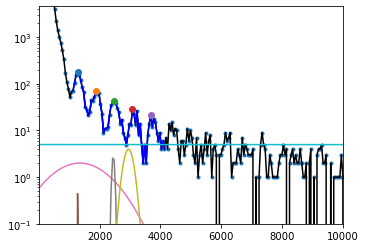

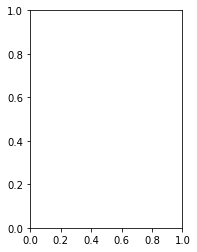

Working on file #9: /gpfs/gibbs/project/david_moore/mpw46/purity_monitor/20230213/step5/mca_keith_29.40OV_source_0.h5
Distance:  5
Guess:  [163, 1077.1697247706422, 50]
Params:  [144.79691507 943.71621395 251.92430738]
fit failed
fit failed
fit failed
fit failed
Guess:  [7, 3281.6100917431195, 50]
Params:  [  10.78118922 3291.34270921  540.79146886]
Guess:  [17, 3532.1146788990827, 50]
Params:  [  10.67386427 2866.53624353 1143.56202569]
fit failed
Guess:  [10, 4383.830275229358, 50]
Params:  [   9.0938126  2209.64402067 2221.9444566 ]
fit failed
Guess:  [10, 4884.839449541285, 50]
Params:  [   7.76956313 3285.07788958 1773.05468245]
[1, 943.716213951111, 127.14084437042538]
[30, nan, nan]
[40, nan, nan]
[49, nan, nan]
[60, nan, nan]
[2, 3291.342709209882, 105.8135986590821]
[3, 2866.5362435288234, 2399.9510324444554]
[78, nan, nan]
[4, 2209.6440206696466, 36200.15362802075]
[92, nan, nan]
[5, 3285.077889584502, 16636.385482516846]


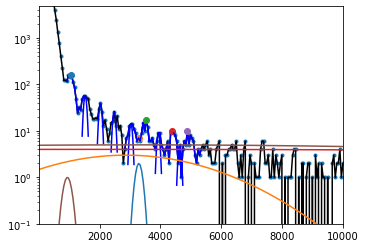

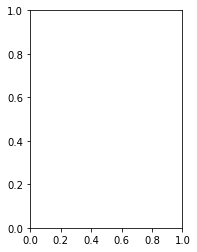

In [65]:
guess_1pe = 1100 * SRS_gain/100 - pedestal ## based on highest gain data
guess_sig = 0.1

distances = [20, 20, 20, 20, 15, 15, 15, 10, 10, 5]

gain_vs_volts = []
for i,(file, dist) in enumerate(zip(file_list, distances)): 
    print("Working on file #%d: %s"%(i,file))
    print('Distance: ', dist)

    file_parts = file.split("_")
#     print(file_parts)
    file_volts = float( file_parts[-3][:-2] ) # get voltage from filename
    try:
        file_wavelength = float(file_parts[-2]) # get wavelength from filename
    except ValueError:
        file_wavelength = file_parts[-2] # leaving tag as a string for source data



    f = h5py.File(file, 'r')  
    ch2 = f.get('ch2')
    for key in ch2.keys():
        mca_hist = np.array(ch2.get(key))
    bin_num = np.arange(len(mca_hist))
    b, c = rebin_histogram(bin_num, mca_hist, 50)
    
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.scatter(b, c, marker='.')
    plt.semilogy(b, c, 'k')
    plt.ylim(0.1, np.max(mca_hist)*2)
    plt.xlim(0.1, 10000)

    if(len(gain_vs_volts) > 0):
        guess_1pe = gain_vs_volts[-1][1] * (file_volts-breakdown)/(gain_vs_volts[-1][0]-breakdown) 

    pe_locs, post_bin_x, post_bin_y = find_peaks_and_fit(bin_num, mca_hist, min_distance=dist)
#     plt.xlim(0, guess_1pe*6)


    plt.subplot(1,2,2)
#     print(pe_locs)
#     plt.errorbar( pe_locs[:,0], pe_locs[:,1], yerr=pe_locs[:,2], fmt='ko' )

#     fpts = ~np.isnan(pe_locs[:,1])
#     if(np.sum(fpts) < 3):
#         continue
#     gain_bp, gain_bc = curve_fit( lin_fun, pe_locs[fpts, 0], pe_locs[fpts, 1] )

#     xx = pe_locs[fpts, 0]
#     plt.plot( xx, lin_fun(xx, *gain_bp), 'r')

#     gain_vs_volts.append( [file_volts, gain_bp[0], np.sqrt(gain_bc[0,0]), file_wavelength] )

    plt.show()

In [ ]:
##### print(gain_vs_volts) ## 2nd array - last value looks WAY off
gain_vs_volts = np.array(gain_vs_volts)
wl_to_use = gain_vs_volts[:,3] == 405
print(wl_to_use)
print(np.array(gain_vs_volts[wl_to_use,:]))

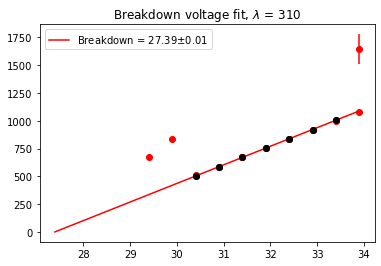

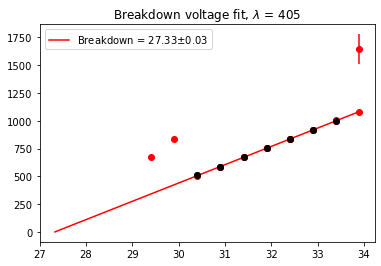

In [49]:
# change to have linear fit for both leds -- will need to use file_parts[-2][:-2] to separate them out -- will need to loop in block above

gain_vs_volts = np.array(gain_vs_volts[::-1])
wavelength = [310, 405]

voltages_to_exclude = [29.4, 29.9, 33.9]

for wl in wavelength:

    rows_to_skip = []
    for v in gain_vs_volts[:,0]:
        if(v in voltages_to_exclude):
            rows_to_skip.append(False)
        else:   
            rows_to_skip.append(True)
    rows_to_skip = np.array(rows_to_skip)
    
    rows_to_use = gain_vs_volts[:,3] == wl #select rows with the desired wavelength
    rows_to_use = rows_to_use & rows_to_skip
    bd_bp, bd_bc = curve_fit(lin_fun, gain_vs_volts[rows_to_use, 0], gain_vs_volts[rows_to_use, 1], sigma=gain_vs_volts[rows_to_use, 2])

    plt.figure()
    plt.errorbar(gain_vs_volts[:,0], gain_vs_volts[:,1], yerr=gain_vs_volts[:,2], fmt='ro')
    plt.errorbar(gain_vs_volts[rows_to_use,0], gain_vs_volts[rows_to_use,1], yerr=gain_vs_volts[rows_to_use,2], fmt='ko')
    #plt.errorbar(gain_vs_volts[~rows_to_use,0], gain_vs_volts[~rows_to_use,1], yerr=gain_vs_volts[~rows_to_use,2], fmt='ro')
    xx = np.linspace(bd_bp[1], np.max(gain_vs_volts[:,0]), 100)
    plt.plot(xx, lin_fun(xx,*bd_bp), 'r', label="Breakdown = %.2f$\pm$%.2f"%(bd_bp[1], np.sqrt(bd_bc[1,1])))
    plt.title("Breakdown voltage fit, $\lambda$ = %d"%wl)
    plt.legend()
    plt.show()

In [45]:
print(rows_to_use)

[False False False  True False  True False  True False  True False  True
 False  True False  True False False]


Found 4 files
Working on file #0: C:/Data/20230213/Step16\mca_keith_31.40OV_source_3.h5


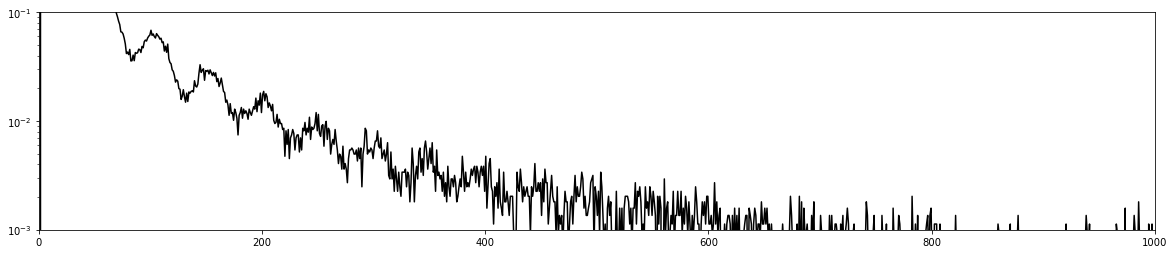

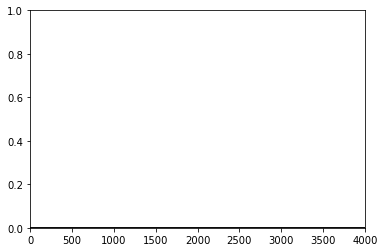

In [107]:
## Plot latest file

path = r"C:/Data/20230213/Step16/"

type_list = ['source']#, '405', '310']
col_list = ['k', 'b', 'purple']
nfiles = 1
norm_range = [3000, 12000] ## set range to normalize counts (leave empty to not use)

ref_hist = 0
fig1 = plt.figure(figsize=(20,4))
fig2 = plt.figure(figsize=(6,4))
for j,t in enumerate(type_list):
    file_list = natsort.realsorted(glob.glob(path + "*mca*%s*.h5"%t))
    print("Found %d files"%len(file_list))


    for i,file in enumerate(file_list[-nfiles:]): 
        print("Working on file #%d: %s"%(i,file))

        #file_parts = file.split("_")
        #file_volts = float( file_parts[-2][:-2] ) # get voltage from filename

        f = h5py.File(file, 'r')  
        ch2 = f.get('ch2')
        for key in ch2.keys():
            mca_hist = np.array(ch2.get(key))
        bin_num = np.arange(len(mca_hist))

        b, c = rebin_histogram(bin_num, mca_hist, 1)

        if(len(norm_range)==2):
            gpts = (b < norm_range[1]) & (b > norm_range[0])
            norm_fac = np.sum(c[gpts])
        else:
            norm_fac = 1

        if(t == "source"):
            ref_hist = c/norm_fac
        plt.figure(fig1.number)
        plt.semilogy(b, c/norm_fac, color=col_list[j])
        plt.ylim(1e-3,1e-1)
        plt.xlim(0,1000)

        plt.figure(fig2.number)
        plt.plot(b, c/norm_fac - ref_hist, color=col_list[j])
        plt.ylim(0,1)
        plt.xlim(0,4000)

plt.show()